# Lab 4: Image Segmentation and Object Detection

This lab covers the fundamentals of image segmentation and object detection, from traditional methods to modern deep learning approaches.

## Learning Objectives

Note from Charity: PLEASE use google to help you if you need. The point is to understand, not to test.

By the end of this lab, you will understand:
- The differences between image classification, object detection, instance segmentation, and semantic segmentation
- Some information about image segmentation
- Traditional segmentation methods
   - Thresholding, Histograms, Edge detection, atlas-based, watershed, Region-based segmentation, Clustering-based segmentation

In [1]:
# Import required libraries
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import filters, measure, morphology, segmentation
from skimage.feature import peak_local_max
from skimage.filters import threshold_multiotsu

from scipy import ndimage
import SimpleITK as sitk

# For visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## What is image segmentation?
Ans: using various techniques/algorithms/functions to annotate individual pixels as belonging to a specific class or instance

*Q: how are "Classic" image segmentation techniques different than deep learning segmentation techniques?*
Ans: 
- Classic image segmentation determine annotations by analyzing inherent qualities of each pixel (called “heuristics”) like color and intensity.
- use neural networks or other models to determine which pixels have which annotations

*what is a model? => this is best explained like: for example a decision tree is a model. A neural network is a model. You cna think of it as a set of rules/patterns that decide a decision. In our case, an example decision can be: "should the pixel be annotated as part of a human lung or empty space?"

How is image segmentation different than:

a) image classification?
- Ans: applies a class- aka a label- to an entire image. Image segmentation is on each pixel.
 
b) object detection?
- Ans: combines image classification with localization of the class inside the image -> generates bounding boxes

# After answering the above, please read the below:

There are two types of image segmentation:
- one type just labels each pixel in the image as a "class"
   - ie: labels a group of pixel as "dog"
- one type not only labels each pixel as a class, but also diffrentiates 
   - ie: labels a group of pixels as "dog #1" and "dog #2". Basically = can seperate multiple instances of the same thing. 

Image segmentation is usually used for one of three things:
1. semantic segmentation
2. instance segmentation
3. panoptic segmentation

The difference between the above 3 tasks is based on how they treat certain types of classes. In Computer Vision, there are TWO types of labels you usually try to label.
1. "Things": Labels that are countable
     ie: car, tree, face.
2. "Stuff": Labels that are highly variable in size, and difficult to count. 
     ie: sand, sky, water, grass <-- for example: one blade of grass is "grass" and so is a field of grass


You don't have to memorize this but:
1. semantic segmentation just tries to label everything as "stuff"
2. instance segmentation tries to separate "things" from "stuff", but does not label "stuff"
3. panoptic segmentation labels both "things" and "stuff"
    - ie: in example below, semantic labels all the cars as "car" but panoptic labels each car individually.

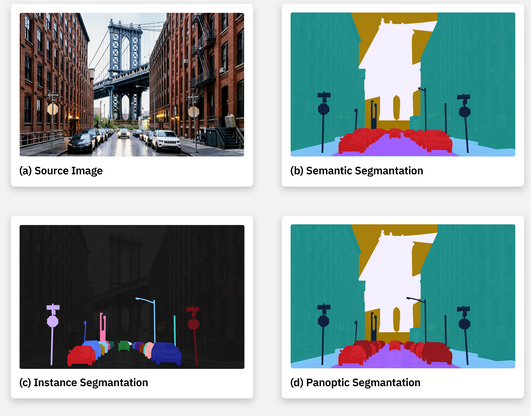

The above information was paraphrased heavily referencing an IBM article. [Full article link](https://www.ibm.com/think/topics/image-segmentation)

TODO:


First Picture is Original Image

Label the following images with the correct label:
- Object Detection
- Object Detection with Multiple Classes
- Semantic Segmentation
- Semantic Segmentation with Multiple Classes

Answers: 
1. original image
2. Semantic Segmentation
3. Semantic Segmentation with Multiple Classes
4. Object Detection
5. Object Detection with Multiple Classes

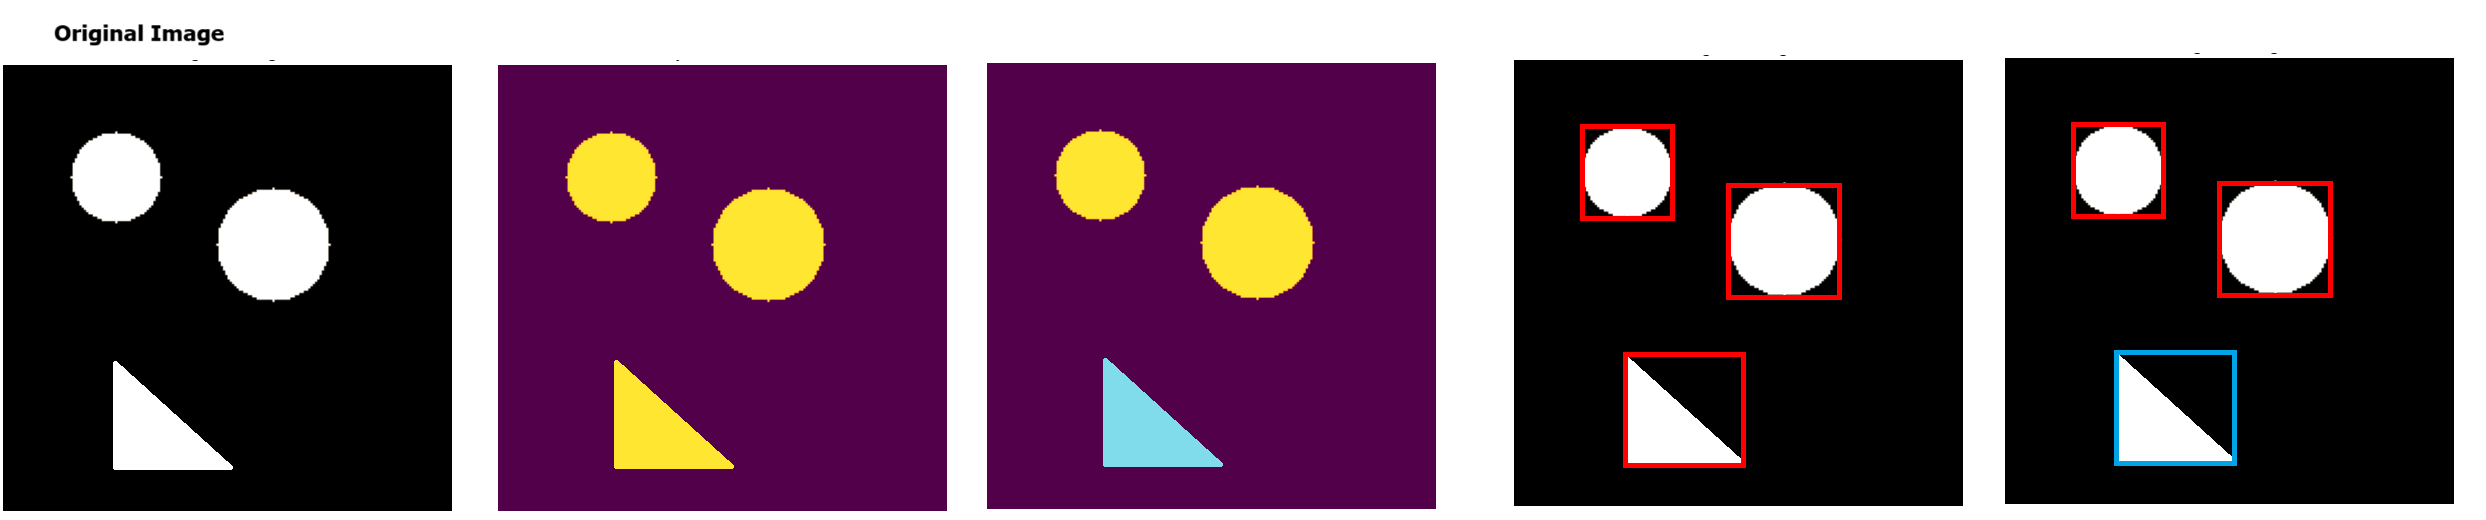

# Import Data

In [2]:
data_folder = '../data/kaggle_2018_dsci_stage1_images_snippet'

solution = data_folder + '/kaggle_2018_dsci_stage1_snippet_solution.csv'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder(data_folder)

In [3]:
default_cmap = plt.rcParams['image.cmap']
def show_original_image_against_new_image(og_image, new_images, new_images_labels, cmap=default_cmap):
    n = len(new_images)
    
    plt.figure(figsize=(10,12))
    plt.subplot(1, n + 1, 1)
    plt.imshow(og_image, cmap=cmap)
    plt.title('Original Image')
    plt.axis('off')

    for i, new_image in enumerate(new_images):
        plt.subplot(1, n + 1, 2 + i)
        plt.imshow(new_image, cmap=cmap)
        plt.title(new_images_labels[i])
        plt.axis('off')
    plt.show()
    plt.tight_layout()
    

## Traditional Segmentation Methods

Before deep learning, computer vision relied on traditional image processing techniques.


- Thresholding-Based
- Histogram-based
- Region-based segmentation
- Edge detection
- atlas-based
- watershed
- Clustering-based segmentation

### Thresholding-Based Segmentation
Thresholding-Based Segmentation separates objects from background based on pixel intensity values.

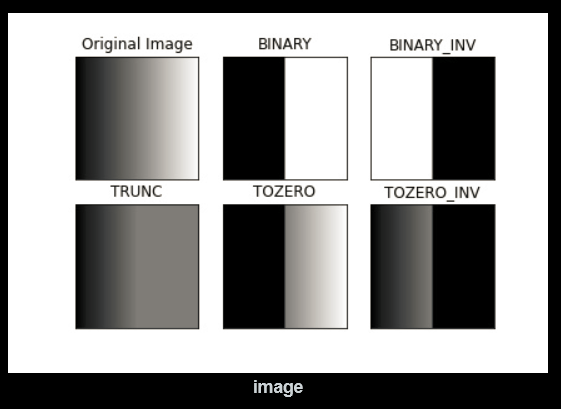


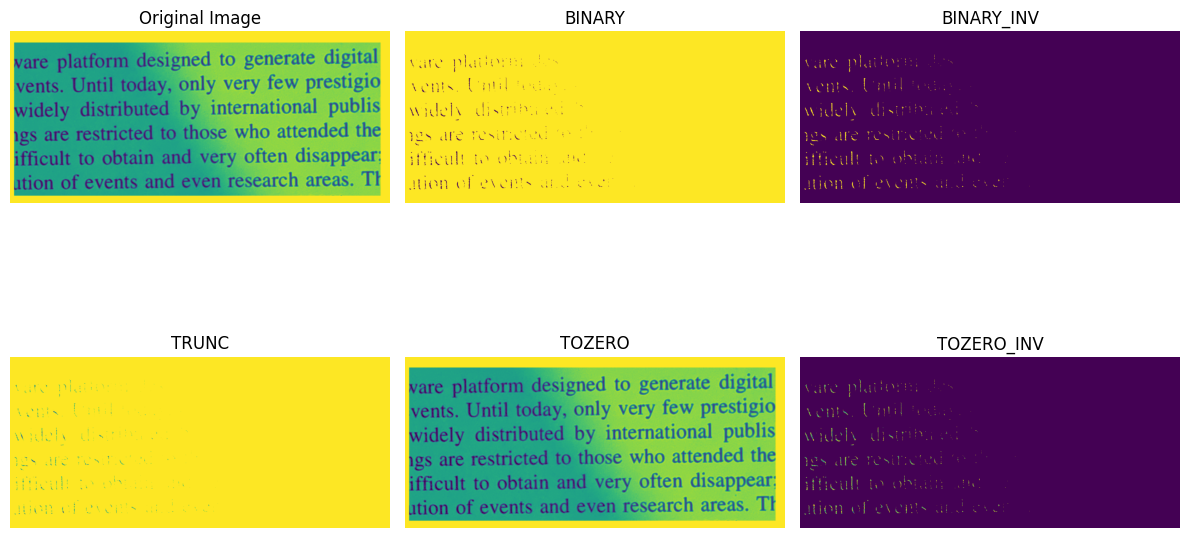

In [4]:
curr_image = cv2.imread('../data/book_scan_gradient.png')
curr_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)


threshold_value = 17 # [0, 255]
ret,thresh1 = cv2.threshold(curr_image,threshold_value,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(curr_image,threshold_value,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(curr_image,threshold_value,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(curr_image,threshold_value,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(curr_image,threshold_value,255,cv2.THRESH_TOZERO_INV)
 
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
thresh_images = [curr_image, thresh1, thresh2, thresh3, thresh4, thresh5]
 
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(thresh_images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

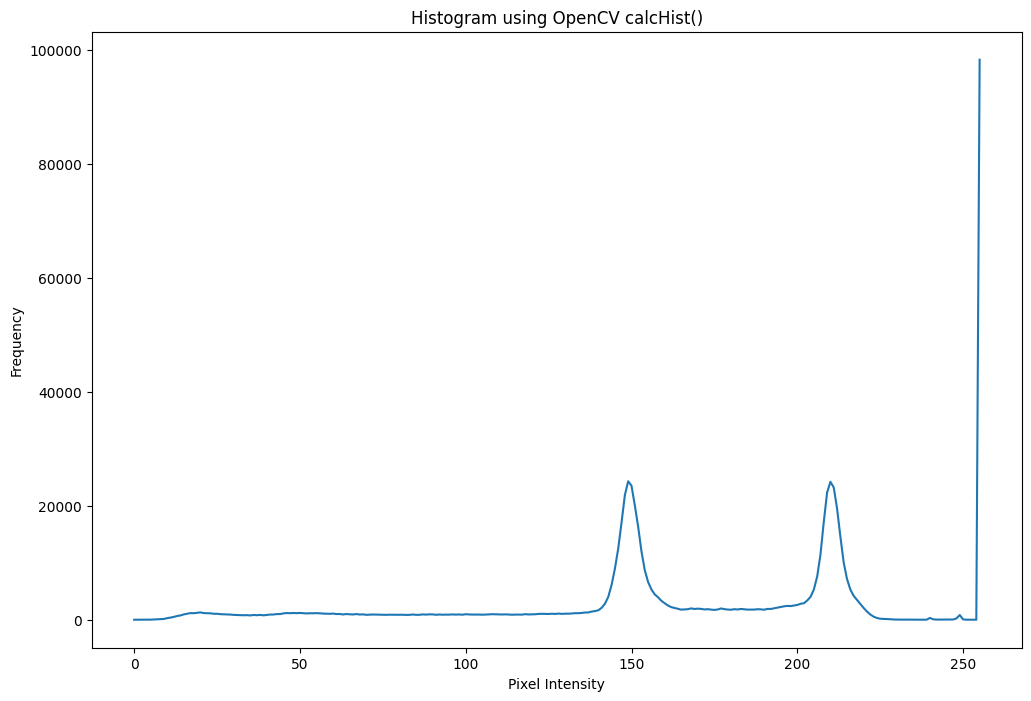

In [5]:
# Question: 
# How can you use the following lines of code (generates image histogram) to explain why image binarization didn't work very well?

histg = cv2.calcHist([curr_image], [0], None, [256], [0, 256])
plt.plot(histg)
plt.title("Histogram using OpenCV calcHist()")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

# Ans: TODO
# The threshhold value can be found between at multiple locations

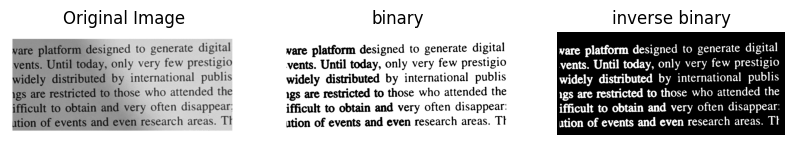

<Figure size 1200x800 with 0 Axes>

In [6]:
#Now try changing the threshold value according to the histogram
#TODO try values between 0 and 100, 150 and 200, and then between 225 and 250

threshold_value = 135
ret, thresh = cv2.threshold(curr_image, threshold_value, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(curr_image, threshold_value, 255, cv2.THRESH_BINARY_INV)
show_original_image_against_new_image(curr_image, [thresh, thresh2], ['binary', 'inverse binary'], 'gray')

# threshold_value = 175
# ret, thresh = cv2.threshold(curr_image, threshold_value, 255, cv2.THRESH_BINARY)
# ret, thresh2 = cv2.threshold(curr_image, threshold_value, 255, cv2.THRESH_BINARY_INV)
# show_original_image_against_new_image(curr_image, [thresh, thresh2], ['binary', 'inverse binary'])

# threshold_value = 240
# ret, thresh = cv2.threshold(curr_image, threshold_value, 255, cv2.THRESH_BINARY)
# ret, thresh2 = cv2.threshold(curr_image, threshold_value, 255, cv2.THRESH_BINARY_INV)
# show_original_image_against_new_image(curr_image, [thresh, thresh2], ['binary', 'inverse binary'])

### Histogram Based segmentation

Histogram-based image segmentation is a technique where the threshold is determined for you, instead of you manually deriving it.

For example, above, we found a great threshold by looking at the histogram manually, but what if your data is a bit more complicated? Luckily, there are pre-made algorithms that divide your image into 1 or more thresholds! 

For example, the Otsu algorithm is often known as a way to do "automatic thresholding" since it calculates the best threshold value for image for you.

Reference: https://medium.com/@mamchinn/unleashing-the-potential-of-histogram-segmentation-for-image-segmentation-d3fe92a1db25

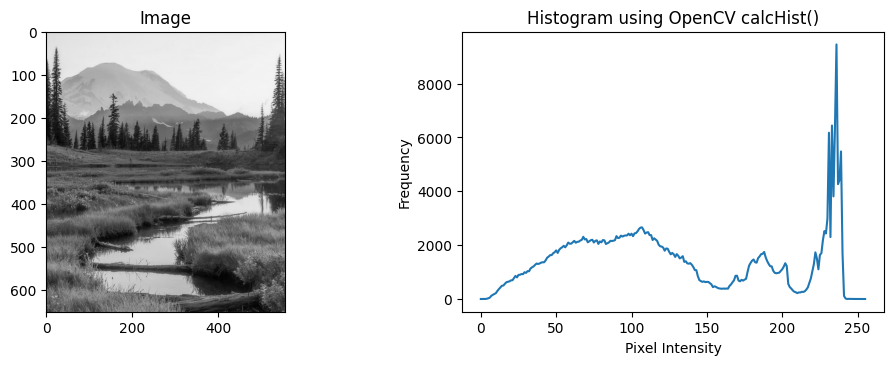

In [7]:
# Notice, how I had to convert the image to grayscale. Optional Question: why?
# Ans: because otherwise I would have to create a histogram for each rgb channel and find threshold for that, which takes too long so this is quicker

curr_image = cv2.imread('../data/landscape_histogram_photo.png')
gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)
plt.subplot(2,2,1)
plt.imshow(gray, cmap='gray')
plt.title("Image")

#todo generate histogram in second subplot
plt.subplot(2,2,2)
histg = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.plot(histg)
plt.title("Histogram using OpenCV calcHist()")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


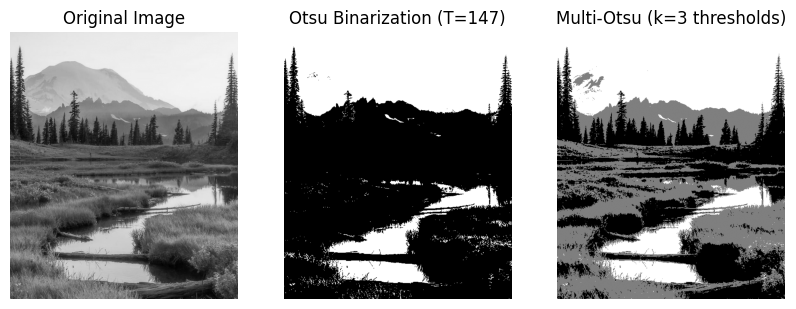

<Figure size 1200x800 with 0 Axes>

In [8]:
# --- 1) Otsu's method (single threshold) ---
ret_otsu, mask_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
otsu_thresh = ret_otsu  # threshold value from Otsu

# --- 2) Multi-Otsu (k classes) ---
k = 3  # number of desired different classes, TODO, play around with increasing k!
multi_thresh = threshold_multiotsu(gray, classes=k)
# threshold_multiotsu returns k-1 threshold values
# build labeled image from thresholds
regions = np.digitize(gray, bins=multi_thresh)

# map regions to 0..255 to map each region seperated by otsu thresholds for visualization
mapped_multi = (regions / (regions.max())) * 255
mapped_multi = mapped_multi.astype(np.uint8)

show_original_image_against_new_image(gray, [mask_otsu, mapped_multi], [f"Otsu Binarization (T={int(otsu_thresh)})", f'Multi-Otsu (k={k} thresholds)'], 'gray')

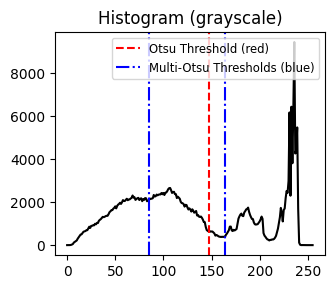

In [9]:
# Here in the histogram you can see the derived Otsu thresholds 
plt.subplot(3,4,1) 
plt.title('Histogram (grayscale)')
hist_plot = cv2.calcHist([gray], [0], None, [256], [0,256]).ravel()
plt.plot(hist_plot, color='black')

# draw Otsu and Multi-Otsu threshold lines
# Note we are declaring it as variables to mark in legend later
line_otsu = plt.axvline(ret_otsu, color='red', linestyle='--')

# draw each multi-otsu threshold as blue dashed lines; capture the first handle for legend
multi_handles = []
for t in multi_thresh:
    h = plt.axvline(t, color='blue', linestyle='-.')
    multi_handles.append(h)

# legend
custom_handles = [line_otsu, multi_handles[0]]
custom_labels = ['Otsu Threshold (red)', 'Multi-Otsu Thresholds (blue)']
plt.legend(custom_handles, custom_labels, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

### Region-based segmentation? 

Well since Otsu seems to work so great, what are the downsides? 
Take a look at image below

C:\Users\Hello\AppData\Local\Temp\ipykernel_13684\223396450.py:7: UserWarning: threshold_multiotsu is expected to work correctly only for grayscale images; image shape (512, 512, 3) looks like that of an RGB image.
  multi_thresh = threshold_multiotsu(gray, classes=k)


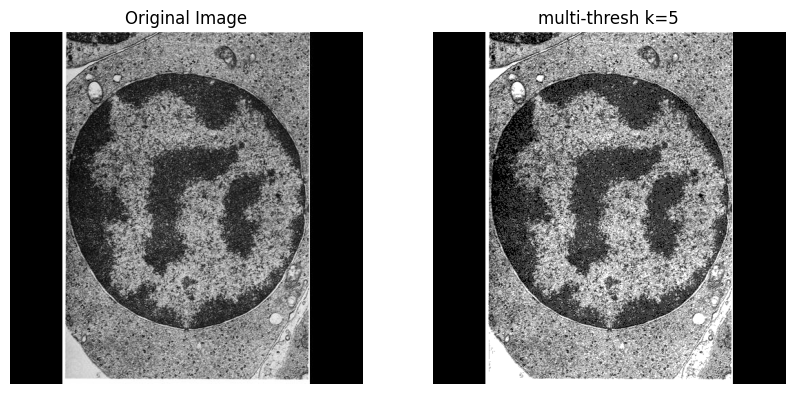

<Figure size 1200x800 with 0 Axes>

In [11]:
# REGION BASED 
curr_image = cv2.imread('../data/chap4_theCell_2ndEd_by_Don_W_Fawcett_MD.jpg')
gray = curr_image
# gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY) #image is already grayscale but 

k = 5
multi_thresh = threshold_multiotsu(gray, classes=k)
regions = np.digitize(gray, bins=multi_thresh)
mapped_multi = (regions / (regions.max())) * 255
mapped_multi = mapped_multi.astype(np.uint8)


show_original_image_against_new_image(curr_image, [mapped_multi], [f'multi-thresh k={k}'])

# question: why don't you see any useful segmentation? Even if you change k? TODO
# Ans: inside of cell is similar pixel intensity as outside. Also the image is very noisy


### Watershed-Based Segmentation

One example of region based algorithm.

Treats the image as a topographic map and finds watershed lines to separate objects. 

#### Watershed Algorithm

How to segments the image is it treats the image as a topographic surface. So it identifying peaks and valleys based on pixel intensity. Local minima are marked as starting points, and flooding with colors fills catchment basins until object boundaries are reached..

The whole process of the watershed algorithm can be summarized in the following steps:

- Marker placement: The first step is to place markers on the local minima, or the lowest points, in the image. These markers serve as the starting points for the flooding process.
- Flooding: The algorithm then floods the image with different colors, starting from the markers. As the color spreads, it fills up the catchment basins until it reaches the boundaries of the objects or regions in the image.
- Catchment basin formation: As the color spreads, the catchment basins are gradually filled, creating a segmentation of the image. The resulting segments or regions are assigned unique colors, which can then be used to identify different objects or features in the image.
- Boundary identification: The watershed algorithm uses the boundaries between the different colored regions to identify the objects or regions in the image. The resulting segmentation can be used for object recognition, image analysis, and feature extraction tasks.

NO PEAKS WERE FOUND- see distance transform imaage as there weren't high enough contrast


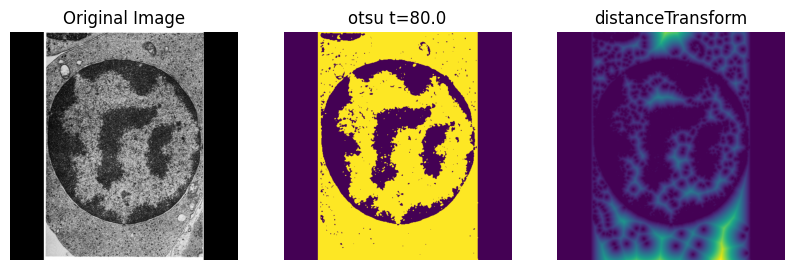

<Figure size 1200x800 with 0 Axes>

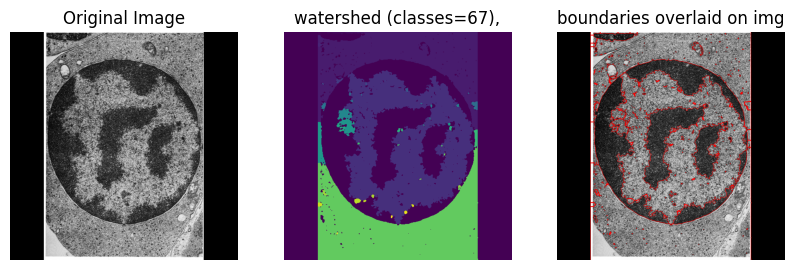

<Figure size 1200x800 with 0 Axes>

In [14]:
def watershed_demo(img, min_distance=20, local_max_threshold=0.1):
    """
    - images: list of images (grayscale or BGR). If not available, pass a single image.
    - index: which image in the list to use.
    - min_distance: minimum distance between local maxima seeds.
    - local_max_threshold: relative threshold for seed detection (fraction of max distance).
    Returns: labels (integer mask) and shows intermediate steps.
    """
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy().astype(np.uint8)

    # 1) Smooth to reduce noise (helps segmentation)
    gray_smooth = cv2.GaussianBlur(gray, (5, 5), 0)

    # 2) Binary foreground mask via Otsu thresholding
    otsu_val, binary = cv2.threshold(gray_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_bool = binary.astype(bool) #convert image to binary values of boolean True/False instead of pixel 0 or 255 

    # 3) Distance transform: compute distance to background for each foreground pixel
    distance = ndi.distance_transform_edt(binary_bool)

    # 4) Find local maxima in the distance map -> candidate seeds for watershed markers
    # peak_local_max returns coordinates of peaks
    peaks = peak_local_max(distance,
                           min_distance=min_distance,
                           threshold_abs=local_max_threshold * distance.max(),
                           labels=binary.astype(np.uint8))
    # create an empty marker image and label the peaks
    markers = np.zeros_like(distance, dtype=np.int32)
    for i, (r, c) in enumerate(peaks, start=1):
        markers[r, c] = i
    # if no peaks were found, at least label connected components of a eroded mask
    if markers.sum() == 0:
        print("NO PEAKS WERE FOUND- see distance transform imaage as there weren't high enough contrast")
        sure_fg = morphology.binary_erosion(binary_bool, morphology.disk(3))
        markers, _ = ndi.label(sure_fg)
    
    # 5) Apply watershed on the (negated) distance map using markers and binary mask
    labels = segmentation.watershed(-distance, markers, mask=binary_bool)
    num_classes = str(len(np.unique(labels)) - 1)

    # overlay watershed boundaries on original
    boundaries = segmentation.find_boundaries(labels, mode='outer')
    overlay = np.zeros((*labels.shape, 3), dtype=np.float32)
    if img.ndim == 2:
        base = np.stack([img]*3, axis=-1) / 255.0
    else:
        base = img.astype(np.float32) / 255.0
    overlay[:] = base
    overlay[boundaries] = [1.0, 0.0, 0.0]  # red boundaries
    
    # 6) Visualizations: original, binary, distance, seeds, watershed labels, boundaries overlay
    
    show_original_image_against_new_image(img, [binary, distance], [f'otsu t={otsu_val:.1f}', 'distanceTransform'])
    show_original_image_against_new_image(img, [labels, overlay], [f'watershed (classes={num_classes}),', 'boundaries overlaid on img'])
    return labels

# curr_image = images[2]
local_max_threshold = 1 # try the value 1, 0.5, 0.1
labels = watershed_demo(curr_image, min_distance=15, local_max_threshold=local_max_threshold)

In [16]:
# now we can get cytoplasm

# flatten matrix to single array
labels_1d = labels.flatten() 

# use pandas function to get the number of pixels (right col) assigned to each label (left col)
pd.Series(labels_1d).value_counts()

# iteratively go through top labels until you get to cytoplasm!

0     127263
9      52339
51     44963
5      33026
36       909
       ...  
39         5
8          4
14         3
20         3
50         3
Name: count, Length: 68, dtype: int64

### Atlas based segmentation

Works by mapping a reference "atlas" onto your image to segment.

The atlas image is especially useful when you have a machine running on a very repeatable image (ie: brain MRI). These atlas are usually copyright info, so I will not go into it, but basically the concept is here.

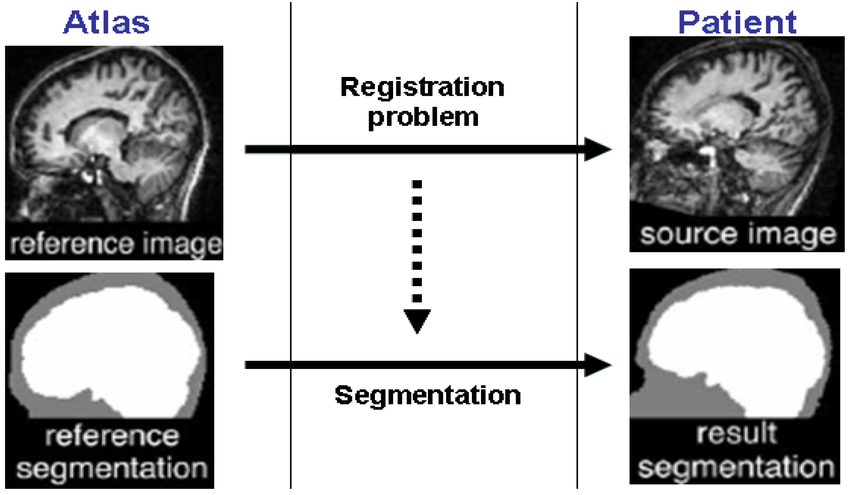

### Clustering

Not strictly region-based, but can produce very region based results.

For example, the k-means clustering algorithm for data can easily be applied to images as well.

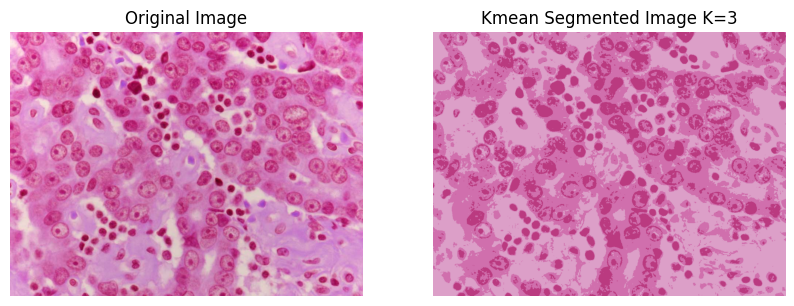

<Figure size 1200x800 with 0 Axes>

In [17]:
use_image = cv2.imread('../data/Prostate-cancer-Slide2-BLOG-960x720-1.jpg')

 # Reshape image for k-means
pixel_values = use_image.reshape((-1, 3)) if len(use_image.shape) == 3 else use_image.reshape((-1, 1))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3 #TODO play with this
attempts=10
ret,label,center=cv2.kmeans(pixel_values,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

centers = np.uint8(center)
segmented_data = centers[label.flatten()]
segmented_image = segmented_data.reshape(use_image.shape)


show_original_image_against_new_image(use_image, [segmented_image], [f"Kmean Segmented Image K={K}"])

### Edge detection

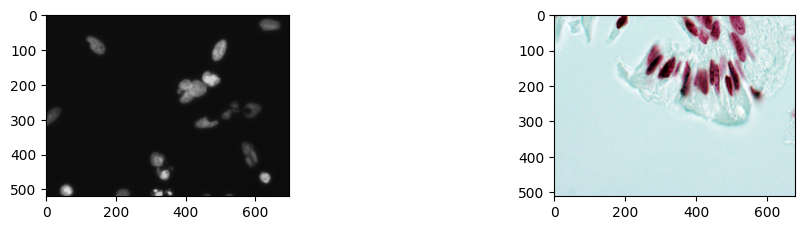

In [18]:
edgeDetect_image1 = images[7]
edgeDetect_image2 = images[8]

plt.subplot(3,2,1)
plt.imshow(edgeDetect_image1)
plt.subplot(3,2,2)
plt.imshow(edgeDetect_image2)

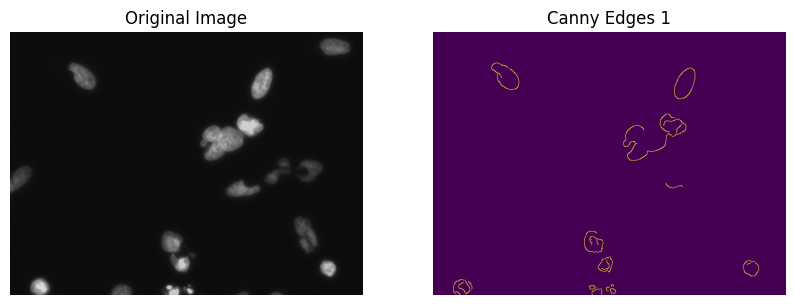

<Figure size 1200x800 with 0 Axes>

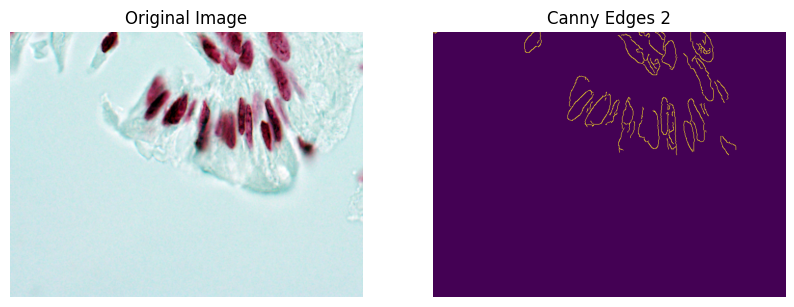

<Figure size 1200x800 with 0 Axes>

In [19]:

def compute_edges_canny(img, low_thresh=50, high_thresh=150, blur_ksize=(5,5)):
    """Return Canny edges for a BGR or grayscale image."""
    if img is None:
        raise ValueError('Input image is None')
    # convert to gray if needed
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
    # optional blur to reduce noise
    blurred = cv2.GaussianBlur(gray, blur_ksize, 0)
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    return edges

# compute edges (tweak thresholds if needed)
edges1 = compute_edges_canny(edgeDetect_image1, low_thresh=50, high_thresh=150)
edges2 = compute_edges_canny(edgeDetect_image2, low_thresh=50, high_thresh=150)

# visualize originals and edges

show_original_image_against_new_image(edgeDetect_image1, [edges1], [f"Canny Edges 1"])
show_original_image_against_new_image(edgeDetect_image2, [edges2], [f"Canny Edges 2"])

## 5. Evaluation Metrics for Segmentation

We did a lot of evaluating with your eyes, which is great! but understanding how to evaluate segmentation performance is important cause we need validation objectively, not just by vibe. This is especially if you are creating a model/algorithm for image segmenting a particular type of images, you need to evaluate the different strategies against each other.

Some metrics- just fyi, do not memorize:
1. **Pixel Accuracy** - Percentage of correctly classified pixels
2. **IoU (Intersection over Union)** - Overlap between prediction and ground truth
3. **Dice Coefficient** - 2 * |A ∩ B| / (|A| + |B|)
4. **Hausdorff Distance** - Maximum distance between boundaries
5. **Mean Average Precision (mAP)** - For object detection/instance segmentation